#  <center> Battle of Neighbourhoods </center>
**<center>By Pedro Rocha</center>**
**<center>11/03/2021</center>**

## 1. Introduction
### 1.1 Background
Ciudad Autónoma de Buenos Aires (Autonomous City of Buenos Aires), is the capital and largest city of Argentina.
Buenos Aires' quality of life was ranked 91st in the world in 2018, being one of the best in Latin America. In 2012, it was the most visited city in South America, and the second-most visited city of Latin America.

According to the World Travel & Tourism Council,tourism has been growing in the Argentine capital since 2002. In a survey by the travel and tourism publication Travel + Leisure Magazine in 2008, visitors voted Buenos Aires the second most desirable city to visit after Florence, Italy.

The city attracts visitors from all over the world, in part because of its rich gastronomic culture.

The gastronomic and hotel industry represented 3.4% of CABA's GDP in 2016

### 1.2 Problem
In this project I'll analyze the neighbourhoods in CABA to find the best ones to start a gastronomic business.

### 1.3 Data
Based on definition of our problem, factors that will influence our decision are:
* Average income for each neighbourhood
* Is the neighbourhood touristic? Is it a Hotel zone?
* Other Touristic Gastronomy Offers in each neighbourhood
* Principal venues in each neighbourhood

In this project I'll be using some Data Sets that you can find in the Buenos Aires Statistics Official Site:


[Gastronomic Offer in CABA](https://data.buenosaires.gob.ar/dataset/oferta-establecimientos-gastronomicos)

[Average total family income (ITF) according to commune. Buenos aires city. Years 2008/2019](https://www.estadisticaciudad.gob.ar/eyc/?p=82453)*

The Average total family income is calculated by commune so I calculated a weighting based on the price of the average M2 for sale in each neighborhood:
[Average price per m2 (dollars) of apartments for sale of 2 used rooms per neighborhood. Buenos aires city. 4th. 2006 / 4th quarter. quarter 2020](https://data.buenosaires.gob.ar/dataset/departamentos-venta/archivo/juqdkmgo-7031-resource)

Also I'll be using the *Foursquare API* to get the principal venues in each neighbourhood. You can check the documentation [HERE](https://developer.foursquare.com/docs)

## 2. Data acquisition and cleaning

In [1873]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import json 
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn import preprocessing
from sklearn.cluster import KMeans
import folium

### 2.1 Data sources

**I'll get the Neighbourhood's names from Wikipedia, you can check the info in [THIS LINK](https://es.wikipedia.org/wiki/Anexo:Barrios_de_la_ciudad_de_Buenos_Aires)**

### 2.2 Data Cleaning

In [1917]:
#Get the list of Wikipedia
url = 'https://es.wikipedia.org/wiki/Anexo:Barrios_de_la_ciudad_de_Buenos_Aires'
df_list = pd.read_html(url)
neigh_df = df_list[0]

#Change the columns name
neigh_df.rename(columns={'Nombre del barrio':'Neighbourhood','Comuna de pertenencia de la Ciudad de Buenos Aires':'Comuna'}, inplace=True)

#Select the info that we need
caba_df = neigh_df.loc[:,['Neighbourhood','Comuna']]
#I'll fix the name of Villa General Mitre with plotting and searching propouse
caba_df.replace(to_replace='Villa Gral. Mitre', value='Villa General Mitre',inplace=True)
caba_df = pd.DataFrame(caba_df)
#I'll fix the values in Column: Comuna, so I can append the average income per Comuna
caba_df['Comuna'] = caba_df['Comuna'].str.replace('Comuna ','').astype(int)
#Let's look a few names
caba_df

,Neighbourhood,Comuna
0,Agronomía,15
1,Almagro,5
2,Balvanera,3
3,Barracas,4
4,Belgrano,13
5,Boedo,5
6,Caballito,6
7,Chacarita,15
8,Coghlan,12
9,Colegiales,13


Get the AVG income per family per commune

In [1923]:
path = r"C:\Users\NOTEBOOK\Desktop\IBM - Data Science\ingreso_por_comuna_familiar.csv"
#Read the file
avg_income = pd.read_csv(path,sep=';',decimal=',')
#Change the column name
avg_income.rename(columns={'Promedio ITF':'AVG Income'},inplace=True)
#Fix the income column, convert into float type, delete $ sign and fix decimal separator (,)
avg_income['AVG Income'] = avg_income['AVG Income'].str.replace('$','').astype(float)
avg_income['AVG Income'] = avg_income['AVG Income'] * 1000
#Merge AVG income into our DataFrame
caba_df = caba_df.merge(avg_income, on='Comuna')

Now I'll read the Weighting file to fix the data

In [1924]:
path = r"C:\Users\NOTEBOOK\Desktop\IBM - Data Science\Ponderator_AVG_income.csv"
#Read File
ponderator_df = pd.read_csv(path, sep=';',encoding='latin-1', decimal=',')
#Get the columns we need
ponderator_df = ponderator_df[['Neighbourhood','Weighting']]
ponderator_df.head()

,Neighbourhood,Weighting
0,Constitución,0.77
1,Montserrat,0.84
2,Puerto Madero,1.84
3,Retiro,1.02
4,San Nicolás,0.75


Get de Weighted Average Income per Neighbourhood

In [1925]:
#Merge Weighting
caba_df = caba_df.merge(ponderator_df, on='Neighbourhood')
#Weight incomes
caba_df['Weighted Income'] = caba_df['AVG Income'] * caba_df['Weighting']
#Select columns we need
caba_df = caba_df[['Neighbourhood','Comuna','Weighted Income']]
#Let's check the data
sorted_income = caba_df.sort_values('Weighted Income', ascending=False)
sorted_income.head(15)

,Neighbourhood,Comuna,Weighted Income
24,Puerto Madero,1,133733.04
14,Belgrano,13,89658.24
39,Palermo,14,85061.00
18,Coghlan,12,80565.30
21,Villa Urquiza,12,79045.20
19,Saavedra,12,77525.10
34,Villa Luro,10,77204.40
40,Recoleta,2,75944.00
15,Colegiales,13,75248.88
16,Núñez,13,75248.88


Let's see the top 10 Neighbourhoods by Average Income

Text(0, 0.5, 'CABA Neighbourhoods')

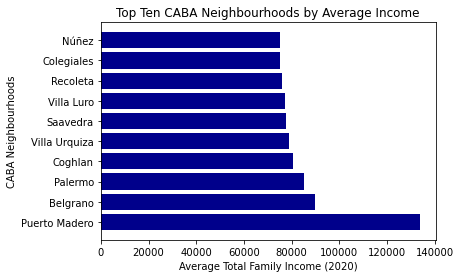

In [1878]:
sorted_income = caba_df.sort_values('Weighted Income', ascending=False)
plt.barh(sorted_income['Neighbourhood'].head(10), sorted_income['Weighted Income'].head(10),color='darkblue')
plt.title('Top Ten CABA Neighbourhoods by Average Income')
plt.xlabel('Average Total Family Income (2020)')
plt.ylabel('CABA Neighbourhoods')

**Ok! Now I need the Neighbourhood's coordinates. For that I'll use geopy. You can see the documentation [HERE](https://pypi.org/project/geopy/)**

In [1879]:
#Now I've the Neighbourhoods, I'll use geopy to get the coordinates.
lats=[]
longs=[]
for neigh in caba_df['Neighbourhood']:
    try:
        address = "{},CABA, AR".format(neigh)
        geolocator = Nominatim(user_agent='caba-agent')
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        lats.append(latitude)
        longs.append(longitude)
    except:
        lats.append(0)
        longs.append(0)

caba_df['lat']=lats
caba_df['long']=longs

In [1880]:
#Ready! Take a look
caba_df.head()

,Neighbourhood,Comuna,Weighted Income,lat,long
0,Agronomía,15,64691.46,-34.591516,-58.485385
1,Chacarita,15,71033.76,-34.588011,-58.454156
2,La Paternal,15,53275.32,-34.597740,-58.470199
3,Parque Chas,15,45030.33,-34.585511,-58.479305
4,Villa Crespo,15,73570.68,-34.598395,-58.442474


Now I'll get the Gastronomic Offer Data Base in order to see which neighbourhoods are a gastronomical point in the city

In [1881]:
#Read the file
path = r"C:\Users\NOTEBOOK\Desktop\IBM - Data Science\oferta_gastronomica.csv"
gastron = pd.read_csv(path,encoding='latin-1',sep=';')
gastron = pd.DataFrame(gastron)
gastron = gastron[['categoria','barrio']]
#Change columns name
gastron.rename(columns={'categoria':'Category','barrio':'Neighbourhood'},inplace=True)
#Select the category we want to focus on
gastron = gastron.loc[gastron['Category']=='RESTAURANTE']
#Count how many Restaurants are in each Neighbourhood
gastron_grouped = gastron.groupby('Neighbourhood').count().reset_index()
gastron_grouped['Gastronomy Places'] = gastron_grouped.sum(axis=1).astype(int)
#Put this info in a new DF and sort it
tourist_gastronomy = gastron_grouped[['Neighbourhood','Gastronomy Places']]
sorted_tourist_gastronomy = tourist_gastronomy.sort_values('Gastronomy Places', ascending=False)
sorted_tourist_gastronomy

,Neighbourhood,Gastronomy Places
19,Palermo,366
29,San Nicolas,315
25,Recoleta,227
1,Balvanera,143
15,Monserrat,100
6,Caballito,87
26,Retiro,78
3,Belgrano,68
30,San Telmo,55
0,Almagro,50


Plot the top 10 Gastronomical Neighbourhoods

Text(0.5, 0, 'Restaurants in the Neighbourhood')

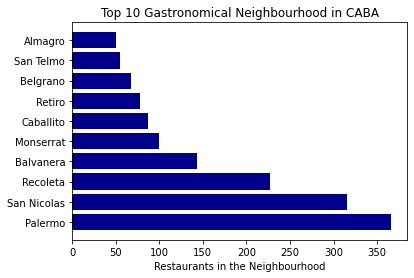

In [1882]:
plt.barh(sorted_tourist_gastronomy['Neighbourhood'].head(10), sorted_tourist_gastronomy['Gastronomy Places'].head(10),color='darkblue')
plt.title('Top 10 Gastronomical Neighbourhood in CABA')
plt.xlabel('Restaurants in the Neighbourhood')

### Now we can see the data in a map! 

In [1883]:
#Lets see the Neighbourhoods in a map!
address = "CABA, AR"
geolocator = Nominatim(user_agent='caba-agent')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_caba = folium.Map(location=[latitude, longitude], zoom_start=11)
for lat, long, neighbourhood in zip(caba_df['lat'],caba_df['long'], caba_df['Neighbourhood']):
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=folium.Popup(str(neighbourhood),parse_html=True),
        color='blue',
        fill=True,
        fill_collor='blue',
        fill_opacity=0.7).add_to(map_caba)
map_caba

C:\Users\NOTEBOOK\anaconda3\lib\site-packages\IPython\core\displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


**Set the credentails to use the Foursquare API**

In [1884]:
#Set up Credentails
CLIENT_ID = 'S2GAOGIEGLVAISTGW1QZ0TG1AEFY3JAGUG12KI5DP1CEUOPX'
CLIENT_SECRET = 'PZVBSTWHX5FRUWDG0CDLI3WUVP3F1EIXYFYFWCDCGA5PFNRZ'
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

I'll set a function to process each Neighbourhood and get the venues.

In [1885]:
#define a function to process neighbourhoods in CABA:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET,
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**Now we can get the venues!**

In [1886]:
#Get the CABA Venues
caba_venues = getNearbyVenues(names=caba_df['Neighbourhood'],
                                   latitudes=caba_df['lat'],
                                   longitudes=caba_df['long'])

Agronomía
Chacarita
La Paternal
Parque Chas
Villa Crespo
Villa Ortúzar
Almagro
Boedo
Balvanera
San Cristóbal
Barracas
La Boca
Nueva Pompeya
Parque Patricios
Belgrano
Colegiales
Núñez
Caballito
Coghlan
Saavedra
Villa Pueyrredón
Villa Urquiza
Constitución
Montserrat
Puerto Madero
Retiro
San Nicolás
San Telmo
Flores
Parque Chacabuco
Floresta
Monte Castro
Vélez Sarsfield
Versalles
Villa Luro
Villa Real
Liniers
Mataderos
Parque Avellaneda
Palermo
Recoleta
Villa del Parque
Villa Devoto
Villa General Mitre
Villa Santa Rita
Villa Lugano
Villa Riachuelo
Villa Soldati


Check how the DataFrame looks.

In [1887]:
caba_venues = pd.DataFrame(caba_venues)
caba_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agronomía,-34.591516,-58.485385,Feria del Productor al Consumidor,-34.593981,-58.483098,Farmers Market
1,Agronomía,-34.591516,-58.485385,Social Parrilla,-34.588955,-58.484677,BBQ Joint
2,Agronomía,-34.591516,-58.485385,Vivero Agronomía,-34.591700,-58.488838,Garden Center
3,Agronomía,-34.591516,-58.485385,Club Arquitectura,-34.589630,-58.484929,Athletics & Sports
4,Agronomía,-34.591516,-58.485385,Corredor Aeróbico de Agronomía,-34.592877,-58.483940,Trail


In order to segment the neighbourhoods we need to know what kind of venues are in each one. Let's see.

I'll use pandas function: *get_dummies* to conver the categorical variable in an indicator variable.

In [1888]:
#Analyze each neighbourhood. What kind of venues does the neighbour has?
caba_venues_cat = pd.get_dummies(caba_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
caba_venues_cat['Neighbourhood'] = caba_df['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [caba_venues_cat.columns[-1]] + list(caba_venues_cat.columns[:-1])
caba_venues_cat = caba_venues_cat[fixed_columns]

caba_venues_cat.head()

,Neighbourhood,Accessories Store,African Restaurant,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Vacation Rental,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Agronomía,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Chacarita,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,La Paternal,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Parque Chas,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Villa Crespo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Now I've processed the information, let group the venues for each Neighbourhood.**

In [1889]:
caba_grouped = caba_venues_cat.groupby('Neighbourhood').mean().reset_index()
caba_grouped.head()

,Neighbourhood,Accessories Store,African Restaurant,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Vacation Rental,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Agronomía,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Almagro,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Balvanera,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Barracas,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Belgrano,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**It would be interesting to see the most common venues in each Neighbourhood. Let's find out..**

In [1890]:
#Function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
#Create a dataframe with the top10 venue categories for each neighbourhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venues'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venues'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = caba_grouped['Neighbourhood']

for ind in np.arange(caba_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(caba_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venues,2nd Most Common Venues,3rd Most Common Venues,4th Most Common Venues,5th Most Common Venues,6th Most Common Venues,7th Most Common Venues,8th Most Common Venues,9th Most Common Venues,10th Most Common Venues
0,Agronomía,Farmers Market,Yoga Studio,Fish Market,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food
1,Almagro,Restaurant,Gaming Cafe,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food,Fondue Restaurant,Flower Shop
2,Balvanera,Burger Joint,Yoga Studio,Garden Center,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food
3,Barracas,Grocery Store,Yoga Studio,Fish Market,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food
4,Belgrano,Bakery,Yoga Studio,Flea Market,Gaming Cafe,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop


I want to know how many hotels are in each Neighbourhood in order to know if it is a Hotel Area

For that I'll use the Foursquare API and get the results for nearby hotels for each Neighbourhood.

Now I'll define a function for this process:

In [1891]:
hotel_category = '4bf58dd8d48988d1fa931735'
#define a function to process neighbourhoods in CABA:
def getNearbyHotels(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&categoryId={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET,
            VERSION,
            hotel_category,
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Explore the hotels in each neighbourhood

In [1892]:
#Get the CABA Hotels
caba_hotels = getNearbyHotels(names=caba_df['Neighbourhood'],
                                   latitudes=caba_df['lat'],
                                   longitudes=caba_df['long'])
print('Hotels Ready!')

Agronomía
Chacarita
La Paternal
Parque Chas
Villa Crespo
Villa Ortúzar
Almagro
Boedo
Balvanera
San Cristóbal
Barracas
La Boca
Nueva Pompeya
Parque Patricios
Belgrano
Colegiales
Núñez
Caballito
Coghlan
Saavedra
Villa Pueyrredón
Villa Urquiza
Constitución
Montserrat
Puerto Madero
Retiro
San Nicolás
San Telmo
Flores
Parque Chacabuco
Floresta
Monte Castro
Vélez Sarsfield
Versalles
Villa Luro
Villa Real
Liniers
Mataderos
Parque Avellaneda
Palermo
Recoleta
Villa del Parque
Villa Devoto
Villa General Mitre
Villa Santa Rita
Villa Lugano
Villa Riachuelo
Villa Soldati
Hotels Ready!


Clean the data and put it sorted by quantity of hotels in each neighbourhood into a Data Frame 

In [1893]:
caba_hotels = pd.DataFrame(caba_hotels)

#Analyze each neighbourhood. What kind of venues does the neighbour has?
caba_hotels_cat = pd.get_dummies(caba_hotels[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
caba_hotels_cat['Neighbourhood'] = caba_hotels['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [caba_hotels_cat.columns[-1]] + list(caba_hotels_cat.columns[:-1])
caba_hotels_cat = caba_hotels_cat[fixed_columns]

#Group the data by Neighbourhood. Sum the hotels in each neighbourhood
caba_hotels_cat = caba_hotels_cat.groupby('Neighbourhood',dropna=False).sum().reset_index()
caba_hotels_cat['Neighbourhood'] = caba_df['Neighbourhood'] 
caba_hotels_cat['Count Hotels'] = caba_hotels_cat.sum(axis=1)
#Select the info I want to conserve
caba_hotels_cat = caba_hotels_cat[['Neighbourhood','Count Hotels']]
#Sort the data
caba_hotels_cat.sort_values('Count Hotels',ascending=False,inplace=True)
#Take a look
caba_hotels_cat.head()

,Neighbourhood,Count Hotels
27,San Telmo,100
31,Monte Castro,100
18,Coghlan,100
28,Flores,100
32,Vélez Sarsfield,96


Plot: Top 10 Neighbourhoods with more hotels

Text(0, 0.5, 'CABA Neighbourhoods')

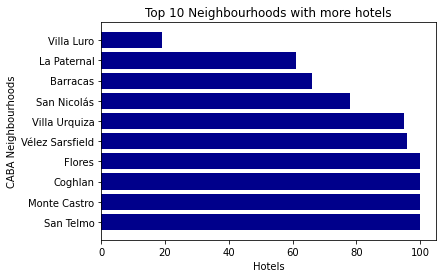

In [1894]:
plt.barh(caba_hotels_cat['Neighbourhood'].head(10), caba_hotels_cat['Count Hotels'].head(10),color='darkblue')
plt.title('Top 10 Neighbourhoods with more hotels')
plt.xlabel('Hotels')
plt.ylabel('CABA Neighbourhoods')

Next step is take the data we have about the hotels and restaurant in each Neighbourhood and categoryze if it's a Gastronomical and/or Hotel Neighbourhood or not.

It will make easier our clustering later.

In [1895]:
#First join all the data together in one DataFrame
caba_merged = caba_df.set_index('Neighbourhood').join(caba_hotels_cat.set_index('Neighbourhood')).fillna(0)
caba_merged['Count Hotels'] = caba_merged['Count Hotels'].astype(int)
caba_merged = caba_merged.reset_index()
caba_merged = caba_merged.set_index('Neighbourhood').join(tourist_gastronomy.set_index('Neighbourhood')).fillna(0)
caba_merged['Gastronomy Places'] = caba_merged['Gastronomy Places'].astype(int) 

#Classify by Hotel Area
is_turistic = []
for hotels in caba_merged['Count Hotels']:
    turistic_neigh = 0
    if hotels > 15:
        turistic_neigh = 1
    is_turistic.append(turistic_neigh)
caba_merged.rename(columns={'Count Hotels':'Hotel Area'}, inplace = True)
caba_merged['Hotel Area'] = is_turistic

#Classify by Gastronomy Places
gastronomy = []
for restaurants in caba_merged['Gastronomy Places']:
    gastronomy_neigh = 0
    if restaurants > 40:
        gastronomy_neigh = 1
    gastronomy.append(gastronomy_neigh)
caba_merged.rename(columns={'Gastronomy Places':'Gastronomy Area'}, inplace = True)
caba_merged['Gastronomy Area'] = gastronomy

#Merge the most common venues in the Data Frame
caba_merged = caba_merged.merge(neighbourhoods_venues_sorted, on='Neighbourhood')

Now we have all the information in one Data Frame. We can take a look to it!

In [1896]:
caba_merged.head()

,Neighbourhood,Comuna,Weighted Income,lat,long,Hotel Area,Gastronomy Area,1st Most Common Venues,2nd Most Common Venues,3rd Most Common Venues,4th Most Common Venues,5th Most Common Venues,6th Most Common Venues,7th Most Common Venues,8th Most Common Venues,9th Most Common Venues,10th Most Common Venues
0,Agronomía,15,64691.46,-34.591516,-58.485385,0,0,Farmers Market,Yoga Studio,Fish Market,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food
1,Chacarita,15,71033.76,-34.588011,-58.454156,1,0,BBQ Joint,Fish Market,Gaming Cafe,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food
2,La Paternal,15,53275.32,-34.597740,-58.470199,1,0,Garden Center,Yoga Studio,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food,Fondue Restaurant
3,Parque Chas,15,45030.33,-34.585511,-58.479305,0,0,Athletics & Sports,Yoga Studio,Fish Market,Gaming Cafe,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop
4,Villa Crespo,15,73570.68,-34.598395,-58.442474,0,0,Trail,Fire Station,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food,Fondue Restaurant


## Clustering

Now it's time to prepare the info to cluster the neighbourhood. For that I'll normalize the Weighted Income and then drop the columns that we don't want in our analysis like the coordinates.

In [1897]:
#Set up the normalizer 
min_max_scaler = preprocessing.MinMaxScaler()
#Put the data in a DF
caba_clustering = caba_merged.iloc[:,0:7]
caba_clustering = caba_clustering.merge(caba_grouped, on='Neighbourhood')
#Normalize the Weighted Average Income
x = caba_clustering[['Weighted Income']].values 
x_scaled = min_max_scaler.fit_transform(x)
caba_clustering[['Weighted Income']] = pd.DataFrame(x_scaled)
#Drop the columns we don't need
caba_clustering.drop(['Neighbourhood','Comuna','lat','long'],1,inplace=True)
caba_clustering.head()

,Weighted Income,Hotel Area,Gastronomy Area,Accessories Store,African Restaurant,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Vacation Rental,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,0.288791,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.354125,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.171192,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.086259,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.380258,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Use the Elbow Method to get the optimal K value

In [1898]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init=12)
    kmeanModel.fit(caba_clustering)
    distortions.append(kmeanModel.inertia_)

Plot the results!

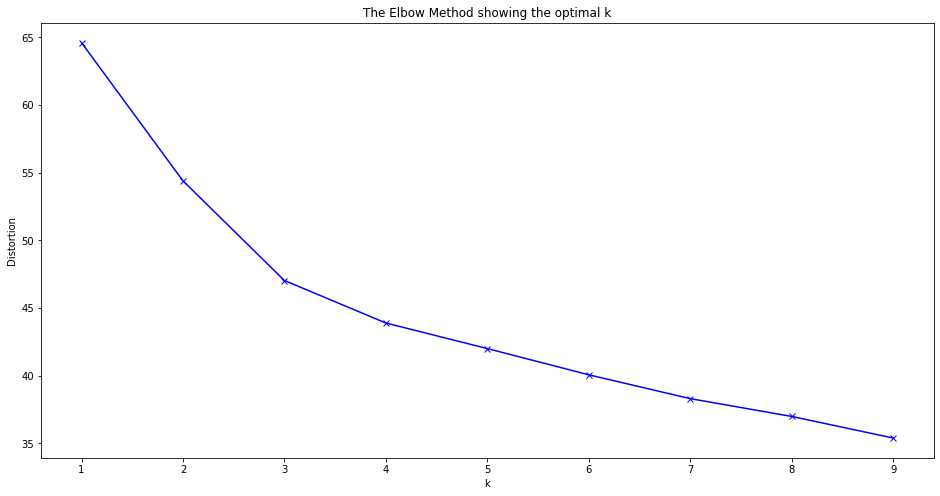

In [1899]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We can see 3 clusters is the optimal K value. 
Now set the kmeans algorithm and get the labels:

In [1900]:
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters= kclusters, n_init=12, random_state=0).fit(caba_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 1, 1, 0, 0, 0, 2, 0, 2, 1, 1, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0, 1,
       0, 0, 2, 2, 1, 2, 2, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0,
       0, 0, 0, 0])

Insert the Cluster Labels in our data frame

In [1901]:
caba_merged.insert(2,'Cluster Labels', kmeans.labels_)
caba_merged

,Neighbourhood,Comuna,Cluster Labels,Weighted Income,lat,long,Hotel Area,Gastronomy Area,1st Most Common Venues,2nd Most Common Venues,3rd Most Common Venues,4th Most Common Venues,5th Most Common Venues,6th Most Common Venues,7th Most Common Venues,8th Most Common Venues,9th Most Common Venues,10th Most Common Venues
0,Agronomía,15,0,64691.46,-34.591516,-58.485385,0,0,Farmers Market,Yoga Studio,Fish Market,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food
1,Chacarita,15,1,71033.76,-34.588011,-58.454156,1,0,BBQ Joint,Fish Market,Gaming Cafe,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food
2,La Paternal,15,1,53275.32,-34.597740,-58.470199,1,0,Garden Center,Yoga Studio,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food,Fondue Restaurant
3,Parque Chas,15,0,45030.33,-34.585511,-58.479305,0,0,Athletics & Sports,Yoga Studio,Fish Market,Gaming Cafe,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop
4,Villa Crespo,15,0,73570.68,-34.598395,-58.442474,0,0,Trail,Fire Station,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food,Fondue Restaurant
5,Villa Ortúzar,15,0,73570.68,-34.581302,-58.468245,0,0,Snack Place,Yoga Studio,Gaming Cafe,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food,Fondue Restaurant
6,Almagro,5,2,59530.41,-34.609988,-58.422233,0,1,Restaurant,Gaming Cafe,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food,Fondue Restaurant,Flower Shop
7,Boedo,5,0,58351.59,-34.630252,-58.418790,0,0,Soccer Field,Yoga Studio,Gaming Cafe,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food,Fondue Restaurant
8,Balvanera,3,2,46279.25,-34.609215,-58.403140,0,1,Burger Joint,Yoga Studio,Garden Center,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food
9,San Cristóbal,3,1,51150.75,-34.624060,-58.402390,1,0,Grocery Store,Yoga Studio,Fish Market,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food


Now we can see how our clusters look in the CABA map

In [1902]:
# create map
caba_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(caba_merged['lat'], caba_merged['long'], caba_merged['Neighbourhood'], caba_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(caba_clusters)
       
caba_clusters

## Conclusions

### Analyze each Cluster

**RED CLUSTER**

This cluster represents the neighborhoods that are not hotel or gastronomic areas

In [1903]:
#Cluster 0 (Red Color)
cluster0 = caba_merged.loc[caba_merged['Cluster Labels'] == 0, caba_merged.columns[[0] + list(range(3, caba_merged.shape[1]))]]
cluster0.drop(['lat','long'],1,inplace=True)
cluster0

,Neighbourhood,Weighted Income,Hotel Area,Gastronomy Area,1st Most Common Venues,2nd Most Common Venues,3rd Most Common Venues,4th Most Common Venues,5th Most Common Venues,6th Most Common Venues,7th Most Common Venues,8th Most Common Venues,9th Most Common Venues,10th Most Common Venues
0,Agronomía,64691.46,0,0,Farmers Market,Yoga Studio,Fish Market,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food
3,Parque Chas,45030.33,0,0,Athletics & Sports,Yoga Studio,Fish Market,Gaming Cafe,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop
4,Villa Crespo,73570.68,0,0,Trail,Fire Station,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food,Fondue Restaurant
5,Villa Ortúzar,73570.68,0,0,Snack Place,Yoga Studio,Gaming Cafe,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food,Fondue Restaurant
7,Boedo,58351.59,0,0,Soccer Field,Yoga Studio,Gaming Cafe,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food,Fondue Restaurant
11,La Boca,46177.82,0,0,Gym / Fitness Center,Yoga Studio,Fish Market,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food
12,Nueva Pompeya,36656.62,0,0,Pizza Place,Yoga Studio,Fire Station,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food,Fondue Restaurant
13,Parque Patricios,53794.78,0,0,Whisky Bar,Yoga Studio,Fire Station,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food
15,Colegiales,75248.88,0,0,Argentinian Restaurant,Yoga Studio,Fish Market,Gaming Cafe,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop
16,Núñez,75248.88,0,0,Theater,Yoga Studio,Fish Market,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food


**PURPLE CLUSTER**

This cluster represents the principal hotel neighbourhoods in CABA

In [1904]:
#Cluster 1 (Purple Color)
cluster1 = caba_merged.loc[caba_merged['Cluster Labels'] == 1, caba_merged.columns[[0] + list(range(3, caba_merged.shape[1]))]]
cluster1.drop(['lat','long'],1,inplace=True)
cluster1

,Neighbourhood,Weighted Income,Hotel Area,Gastronomy Area,1st Most Common Venues,2nd Most Common Venues,3rd Most Common Venues,4th Most Common Venues,5th Most Common Venues,6th Most Common Venues,7th Most Common Venues,8th Most Common Venues,9th Most Common Venues,10th Most Common Venues
1,Chacarita,71033.76,1,0,BBQ Joint,Fish Market,Gaming Cafe,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food
2,La Paternal,53275.32,1,0,Garden Center,Yoga Studio,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food,Fondue Restaurant
9,San Cristóbal,51150.75,1,0,Grocery Store,Yoga Studio,Fish Market,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food
10,Barracas,54270.84,1,0,Grocery Store,Yoga Studio,Fish Market,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food
18,Coghlan,80565.30,1,0,Café,Yoga Studio,Garden Center,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food
21,Villa Urquiza,79045.20,1,0,Spanish Restaurant,Yoga Studio,Gaming Cafe,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food,Fondue Restaurant
26,San Nicolás,54510.75,1,0,Office,Yoga Studio,Fish Market,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food
31,Monte Castro,68197.22,1,0,Indie Theater,Yoga Studio,Fire Station,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food
32,Vélez Sarsfield,57259.93,1,0,Ice Cream Shop,Yoga Studio,Fire Station,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food
34,Villa Luro,77204.40,1,0,Park,Yoga Studio,Gaming Cafe,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food,Fondue Restaurant


**GREEN CLUSTER**

This cluster shows the gastronomy neighbourhoods in CABA and we can see that most are high income too.

THE NEIGHBOURHOODS IN THIS CLUSTER SHOULD BE OUR PRIORITY IF WE WANT TO START A RESTAURANT IN CABA.

In [1905]:
#Cluster 2 (Green color)
cluster2 = caba_merged.loc[caba_merged['Cluster Labels'] == 2, caba_merged.columns[[0] + list(range(3, caba_merged.shape[1]))]]
cluster2.drop(['lat','long'],1,inplace=True)
cluster2

,Neighbourhood,Weighted Income,Hotel Area,Gastronomy Area,1st Most Common Venues,2nd Most Common Venues,3rd Most Common Venues,4th Most Common Venues,5th Most Common Venues,6th Most Common Venues,7th Most Common Venues,8th Most Common Venues,9th Most Common Venues,10th Most Common Venues
6,Almagro,59530.41,0,1,Restaurant,Gaming Cafe,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food,Fondue Restaurant,Flower Shop
8,Balvanera,46279.25,0,1,Burger Joint,Yoga Studio,Garden Center,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food
14,Belgrano,89658.24,0,1,Bakery,Yoga Studio,Flea Market,Gaming Cafe,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop
17,Caballito,69510.00,0,1,Pizza Place,Yoga Studio,Fire Station,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food,Fondue Restaurant
24,Puerto Madero,133733.04,0,1,Cultural Center,Yoga Studio,Fish Market,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food
25,Retiro,74134.62,0,1,Beer Bar,Yoga Studio,Flea Market,Gaming Cafe,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop
27,San Telmo,56691.18,1,1,Sandwich Place,Yoga Studio,Fire Station,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food,Fondue Restaurant
28,Flores,53624.28,1,1,Bar,Yoga Studio,Flea Market,Gaming Cafe,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop
39,Palermo,85061.00,0,1,Office,Yoga Studio,Fish Market,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food
40,Recoleta,75944.00,0,1,Bagel Shop,Yoga Studio,Gaming Cafe,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop,Food
